In [31]:
import sys
sys.path.insert(0, '/home/ading/dev/empirical-mt')

import matplotlib.pyplot as plt

from pelic.gabors import makeGabors, makeGaussian
from pelic.calculate_contrast import CalculateContrast

import pandas as pd

from tqdm import tqdm 

from tuning import DirectionTuning, SpeedTuning, DisparityTuning

import numpy as np

from skimage import io
from skimage.color import rgb2gray
from skimage.transform import resize

import scipy.io as sio

import MT

from keras.layers import Input, Dense, Concatenate, Multiply
from keras.models import Model

size_ = 101
gabors = makeGabors(size_, center=None)
gaussian = makeGaussian(size_, sigma=5, center=None)

contrast_calculator = CalculateContrast(gabors, gaussian)

import tensorflow as tf

In [3]:
from os import listdir
from os.path import isfile, join, split

video_filepath = '../input/vot2017/butterfly/'; 

img_filepaths = [join(video_filepath, f) for f in listdir(video_filepath) 
                 if isfile(join(video_filepath, f)) and f.endswith('.jpg')]

In [4]:
#frame 0
f0 = io.imread(img_filepaths[0])
f0 = rgb2gray(f0)

#img_seq = np.zeros(f0.shape + (len(img_filepaths), ))
img_seq = np.zeros((50, 50) + (len(img_filepaths), ))

for idx, fp in enumerate(img_filepaths):
    frame = io.imread(fp)
    frame = rgb2gray(frame)
    # resize
    frame = resize(frame, (50, 50))
    img_seq[:, :, idx] = frame
    
img_seq = img_seq[:, :, 0:20]

/home/ading/.local/lib/python2.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ading/.local/lib/python2.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


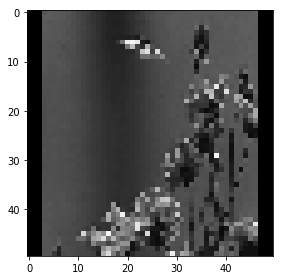

In [5]:
io.imshow(img_seq[:, :, 10])

plt.show()

Contrast

In [47]:
contrast_calculator.sess = tf.Session()
contrast = contrast_calculator.calculate_contrast(img_seq, is_smoothed=False)
contrast_calculator.sess.close()

In [7]:
contrast.shape

(50, 50, 20)

In [8]:
sio.savemat('../data/vot2014/img_seq.mat', {'img_seq': img_seq})

In [9]:
opt_flow = sio.loadmat('../data/vot2014/img_seq_opt_flow.mat')

h_flow = opt_flow['h_flow']
v_flow = opt_flow['v_flow']

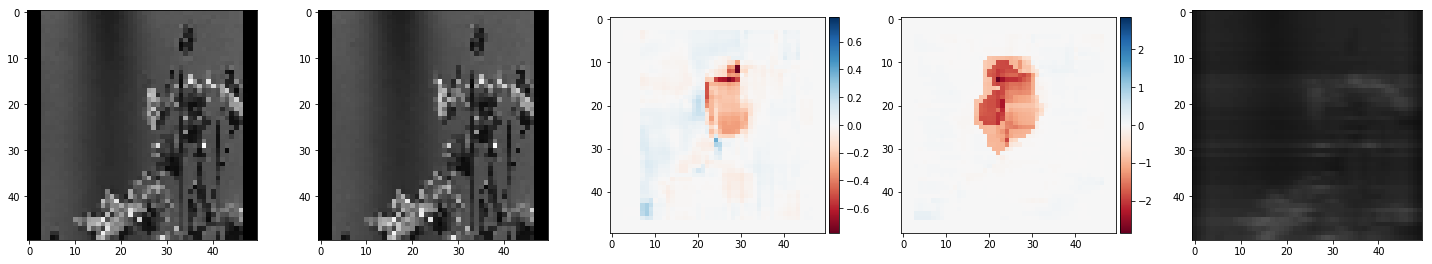

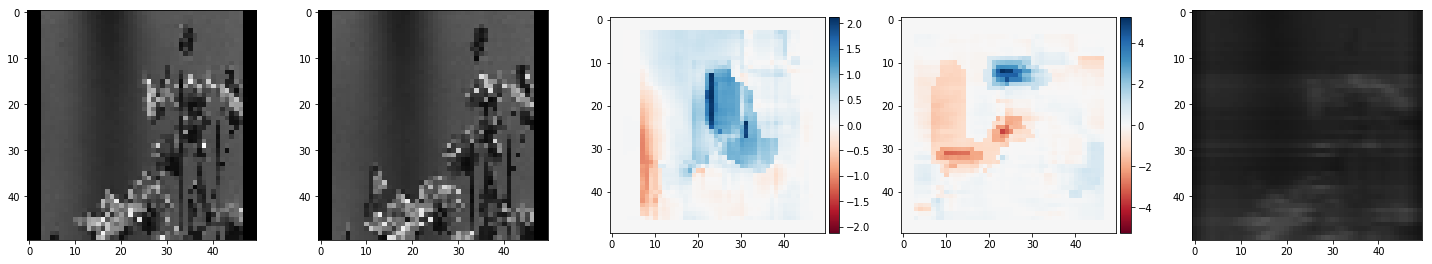

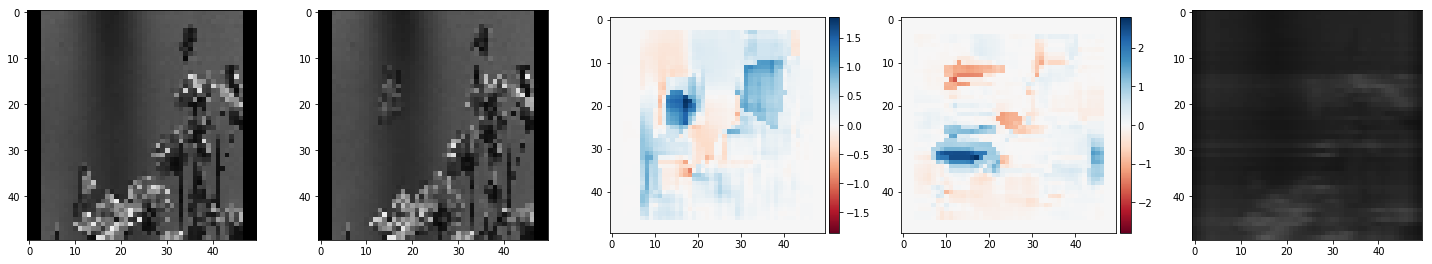

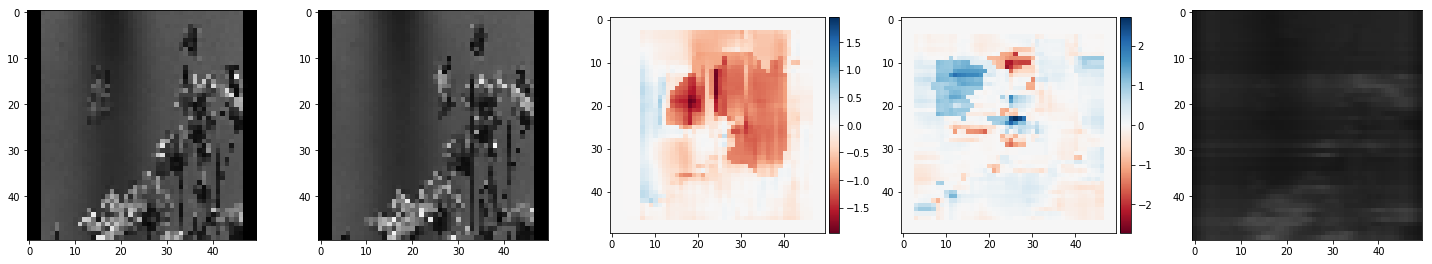

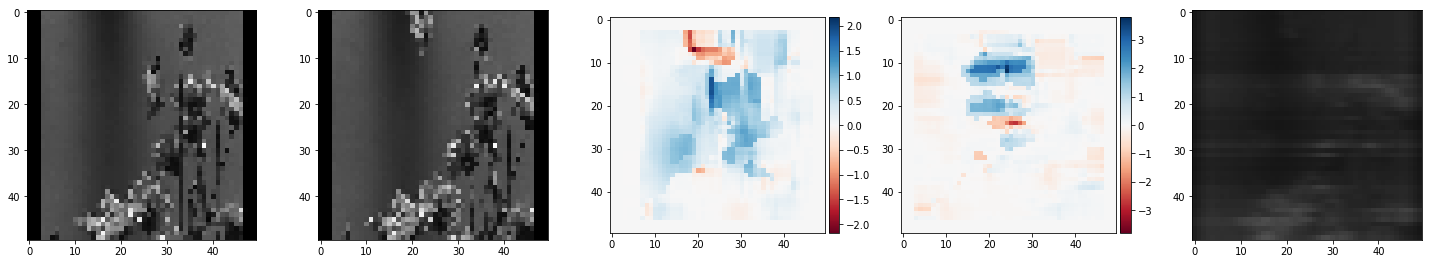

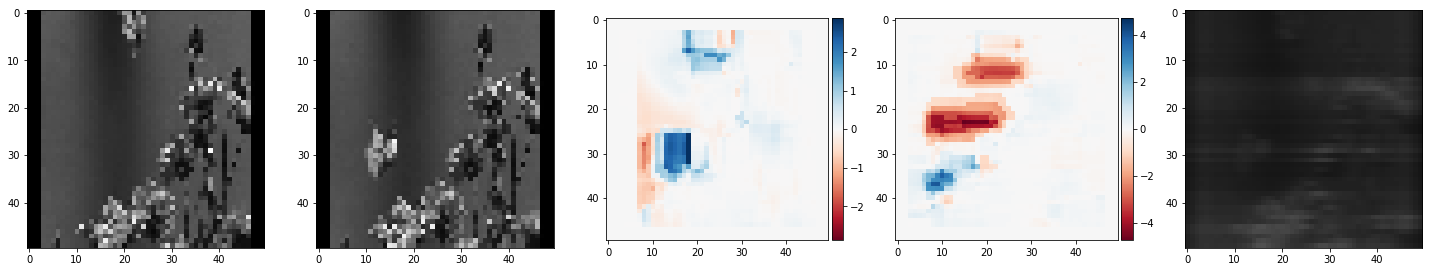

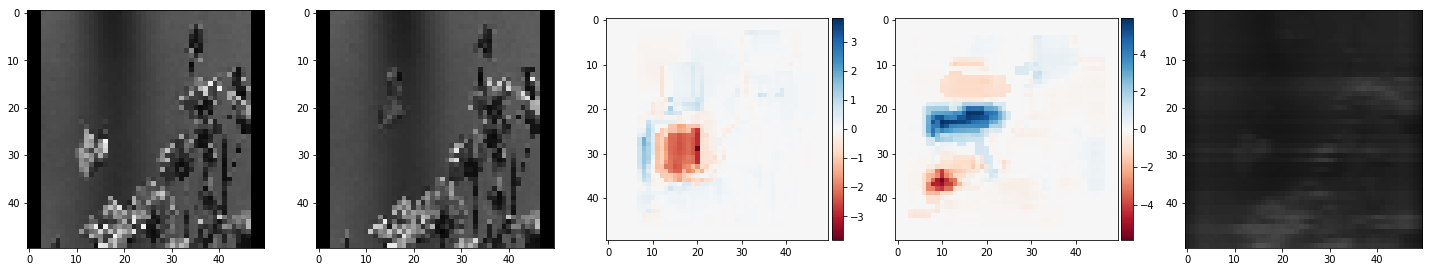

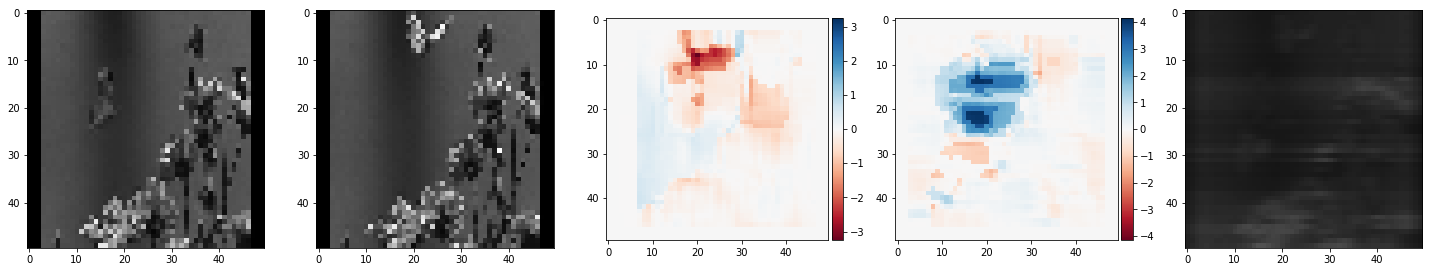

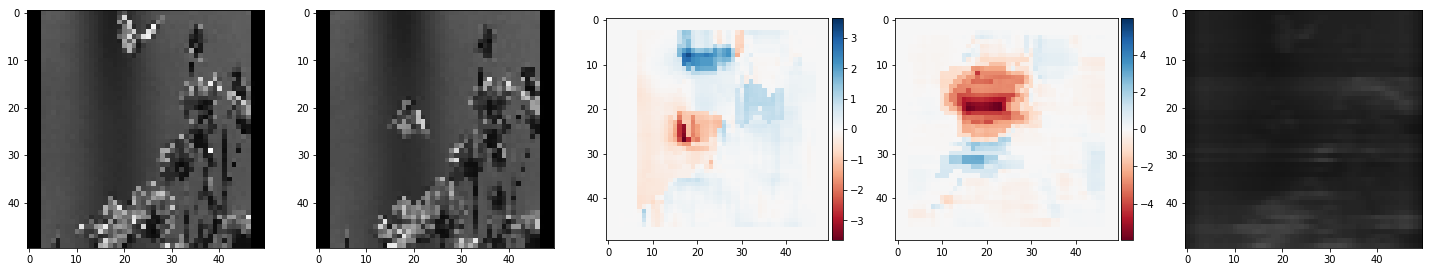

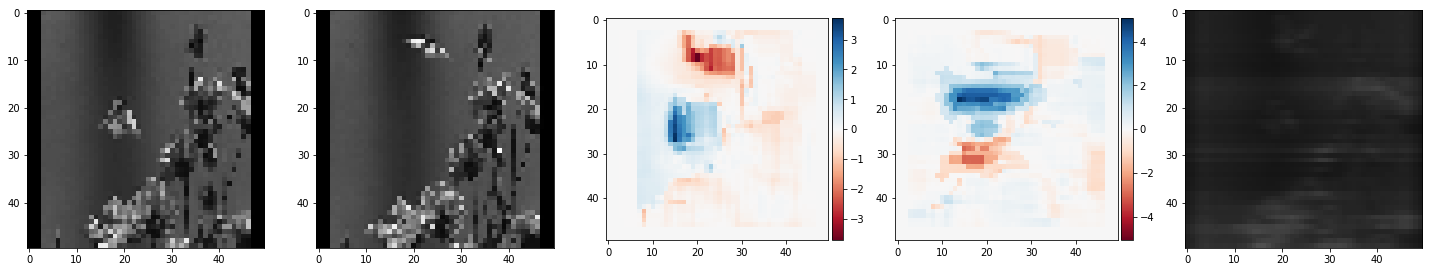

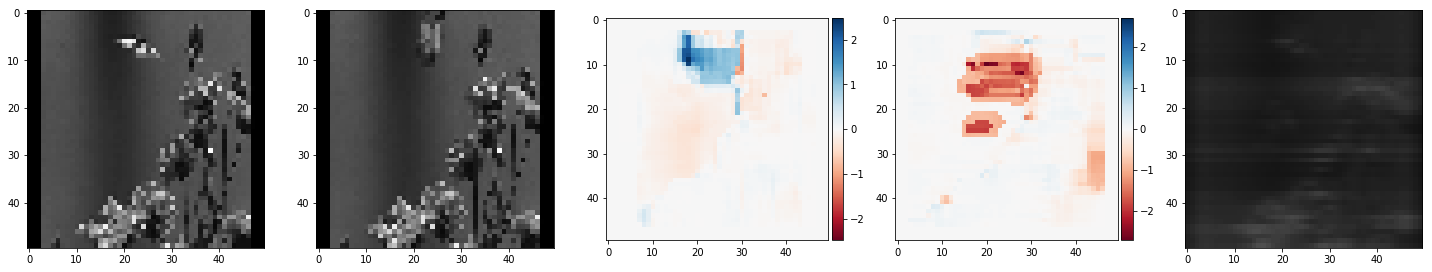

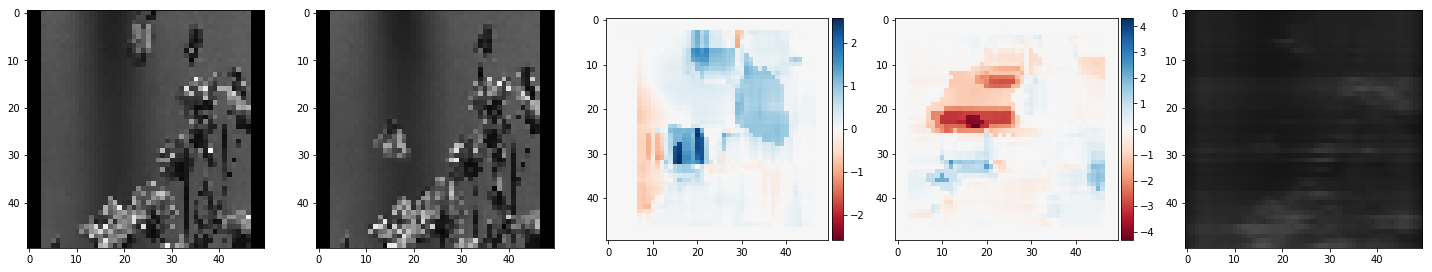

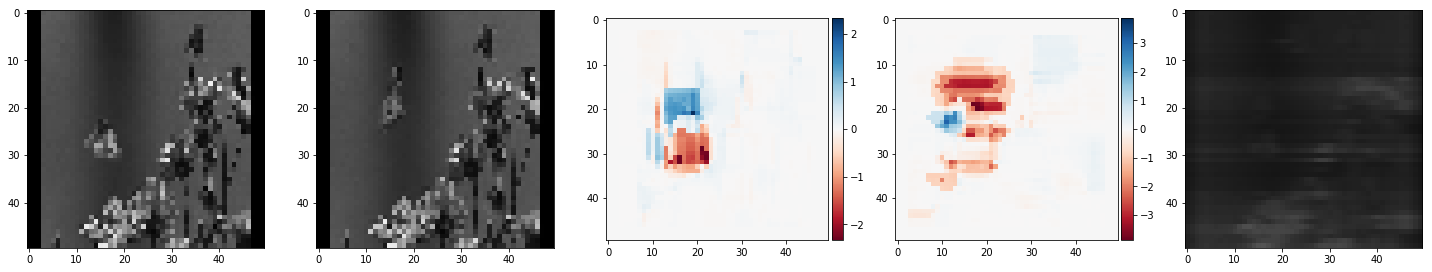

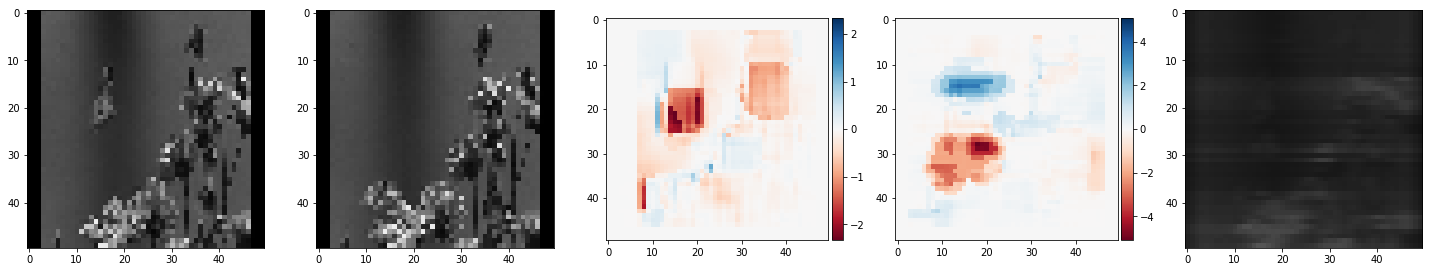

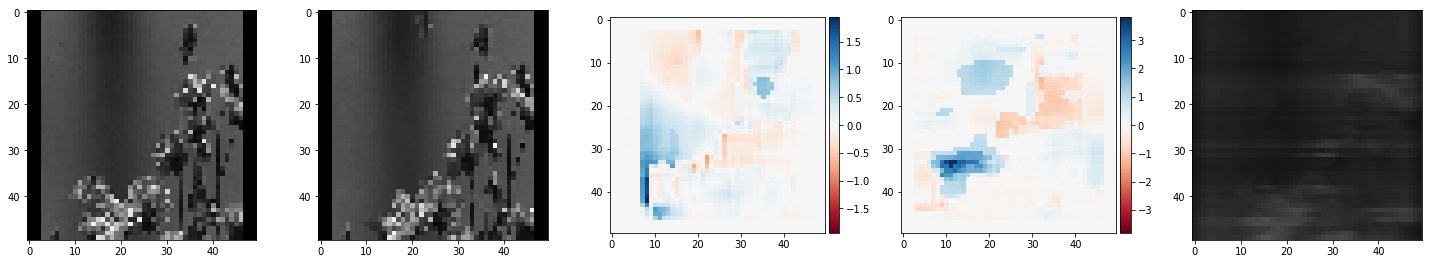

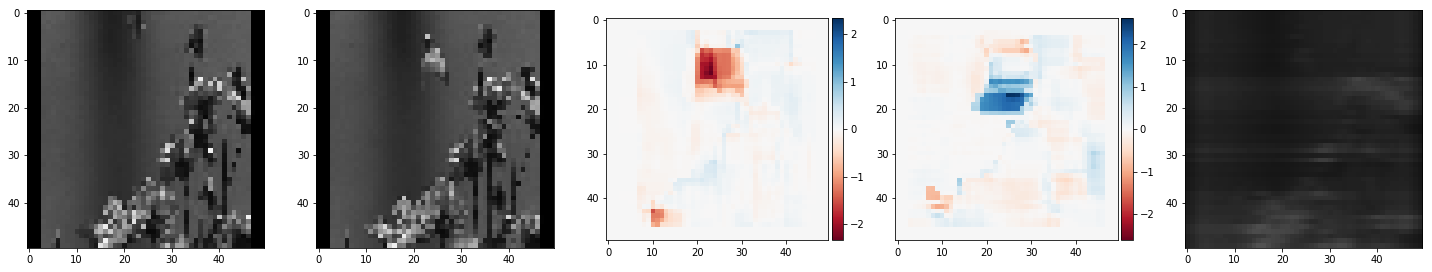

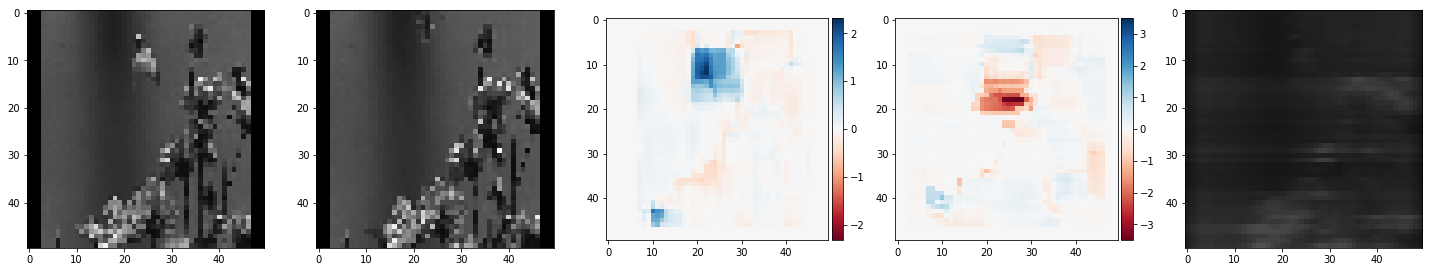

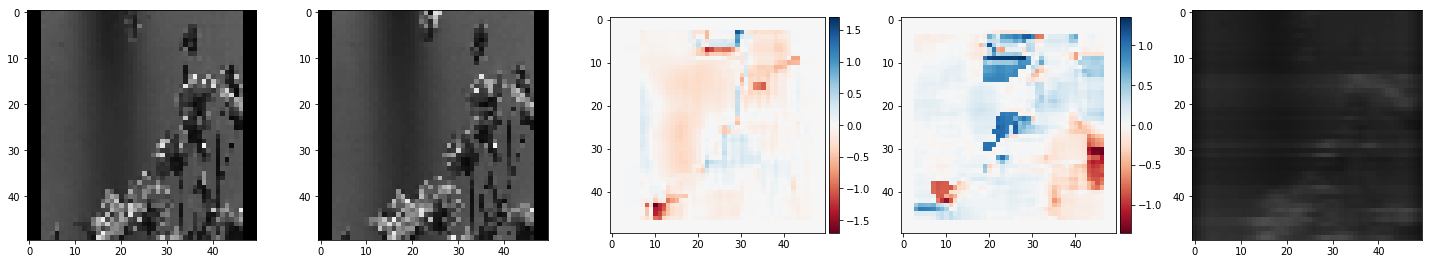

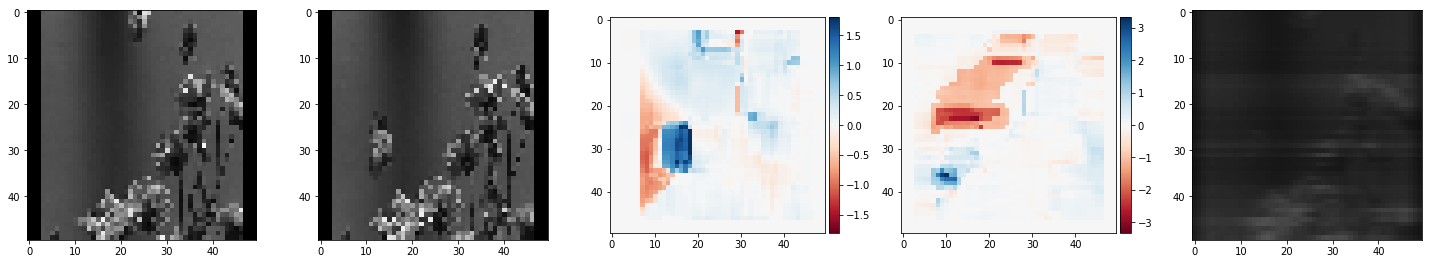

In [10]:

for i in range(0, img_seq.shape[2] - 1):

    plt.figure(figsize=(20, 20))

    plt.subplot(1, 5, 1)
    io.imshow(img_seq[:, :, i])

    plt.subplot(1, 5, 2)
    io.imshow(img_seq[:, :, i+1])

    plt.subplot(1, 5, 3)
    io.imshow(h_flow[:, :, i])
    
    plt.subplot(1, 5, 4)
    io.imshow(v_flow[:, :, i])
    
    plt.subplot(1, 5, 5)
    io.imshow(contrast[:, :, i])

    plt.show()

In [49]:
speed = np.sqrt(np.square(h_flow) + np.square(v_flow))
angular = np.arctan(v_flow / h_flow)
angular = np.nan_to_num(angular)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in divide
  


In [12]:
h_flow.shape

(50, 50, 19)

In [13]:
np.random.seed(1330)
n_channel = 100
n_seq = 1
n_tent = 10
w_ = 76#100
params = MT.sample_tuning_params(n_channel, pref_log_speed_range=(0,4))

/home/ading/.local/lib/python2.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)


In [33]:
in_speed = Input(shape=(50, 50, ))
in_direction = Input(shape=(50, 50, ))
in_contrast = Input(shape=(50, 50, ))

speed_tunning = SpeedTuning(n_channel, params, 100./50 * 25)([in_speed, in_contrast]);
direction_tunning = DirectionTuning(n_channel, params)(in_direction);

mt_feat = Multiply()([speed_tunning, direction_tunning]);

model = Model(inputs=[in_speed, in_direction, in_contrast], outputs = mt_feat)

In [48]:
contrast.shape

(50, 50, 20)

In [50]:
contrast = contrast[:, :, 1:]
contrast = np.swapaxes(contrast, 0, 2)
speed = np.swapaxes(speed, 0, 2)
angular = np.swapaxes(angular, 0, 2)

In [53]:
contrast.shape

(19, 50, 50)

In [54]:
mt_feat_out = model.predict([speed, angular, contrast])

In [55]:
mt_feat_out.shape

(19, 50, 50, 100)

In [ ]:
ave_mt_feat_out = np.average(mt_feat_out, )

In [58]:
len(mt_feat_out.tolist())

19

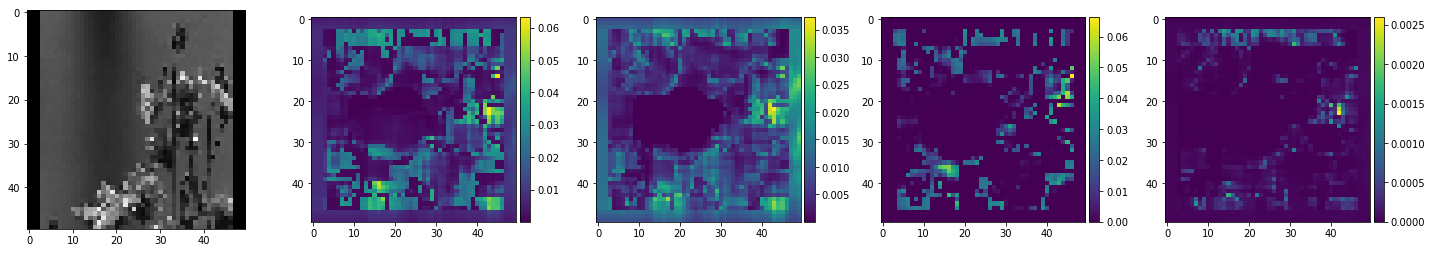

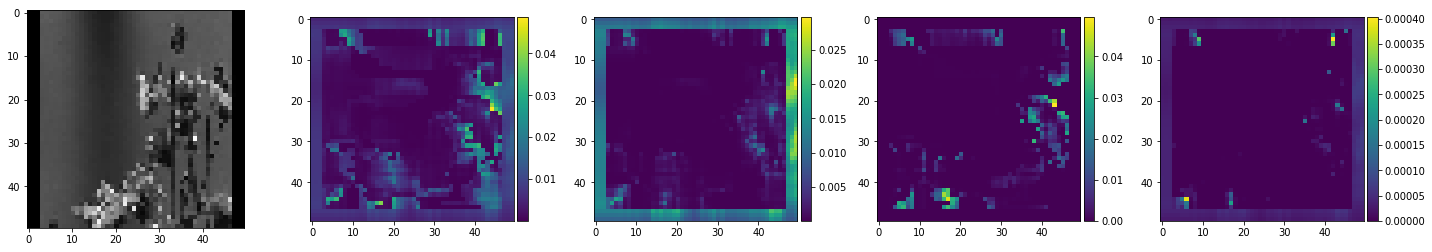

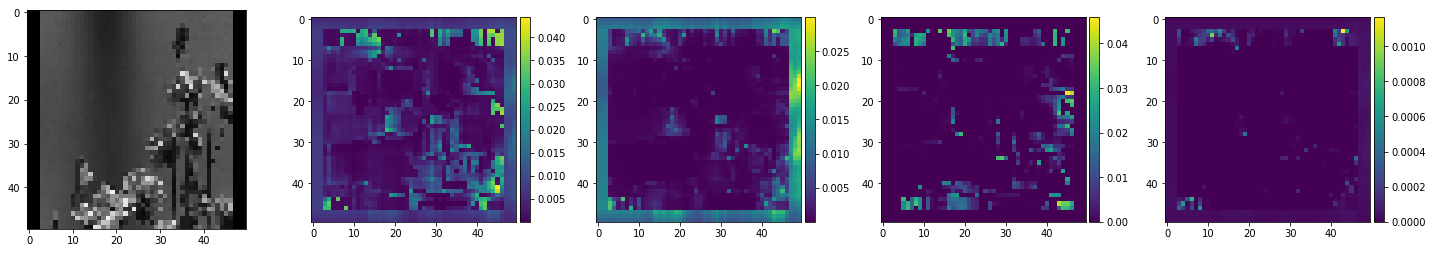

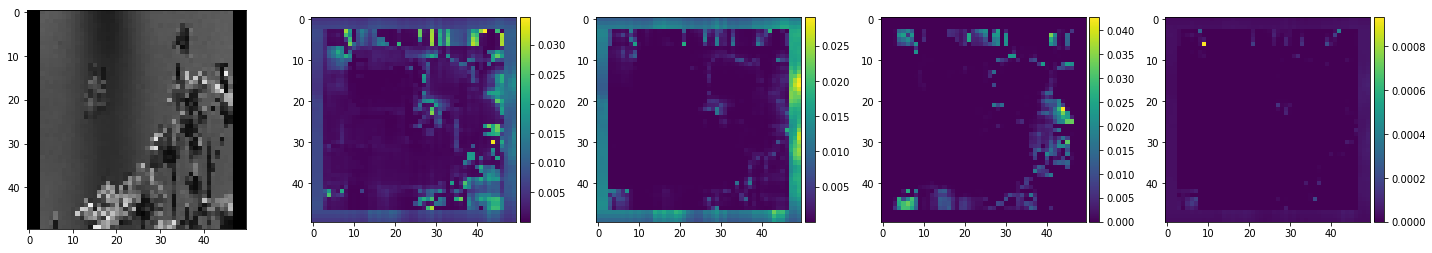

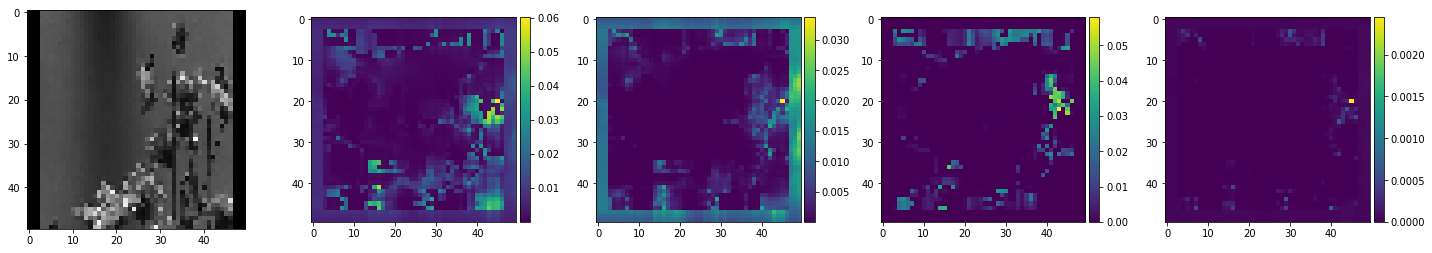

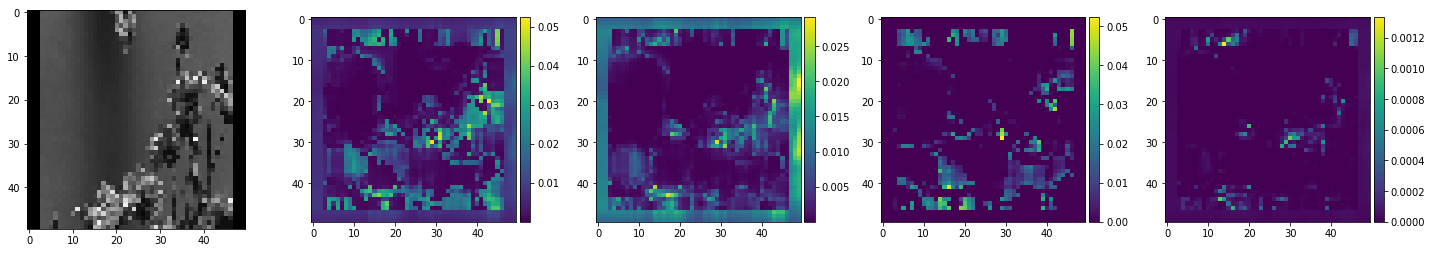

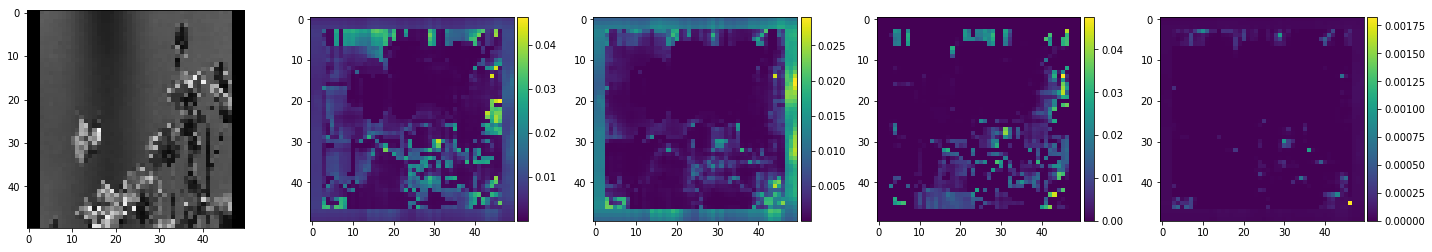

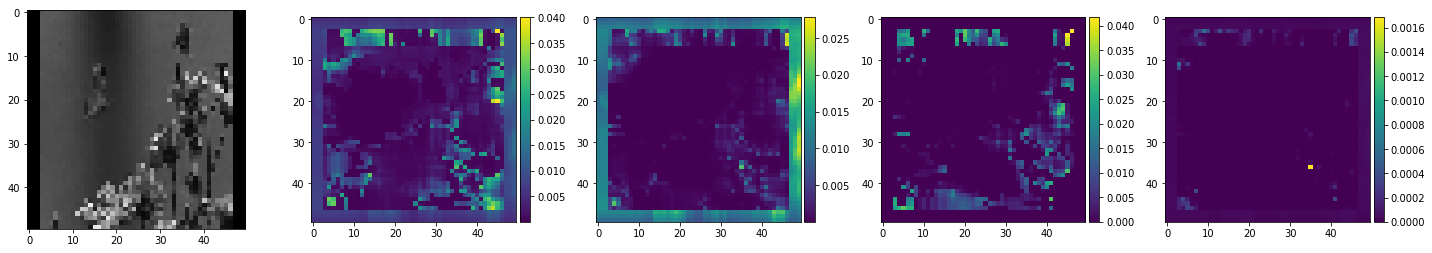

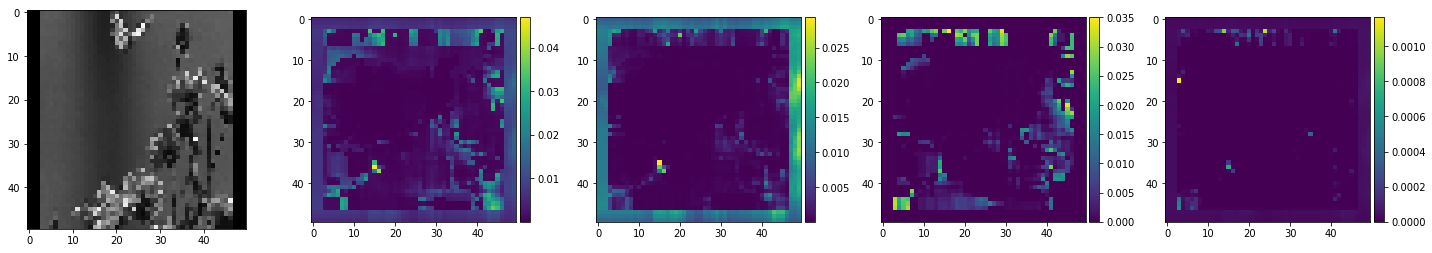

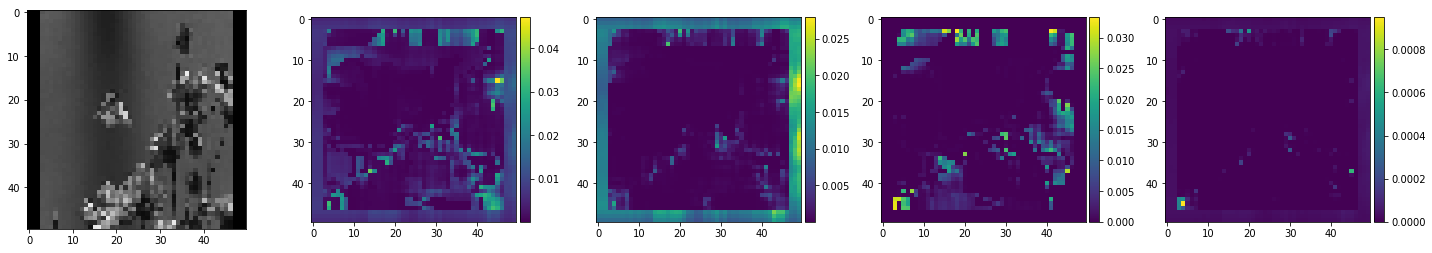

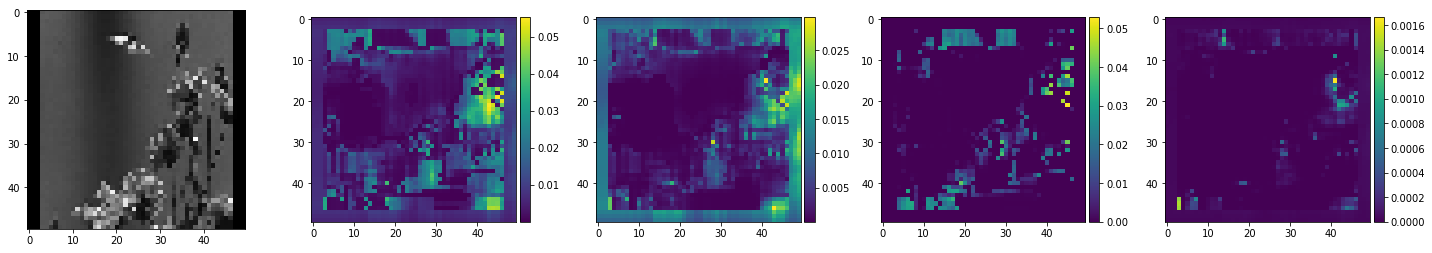

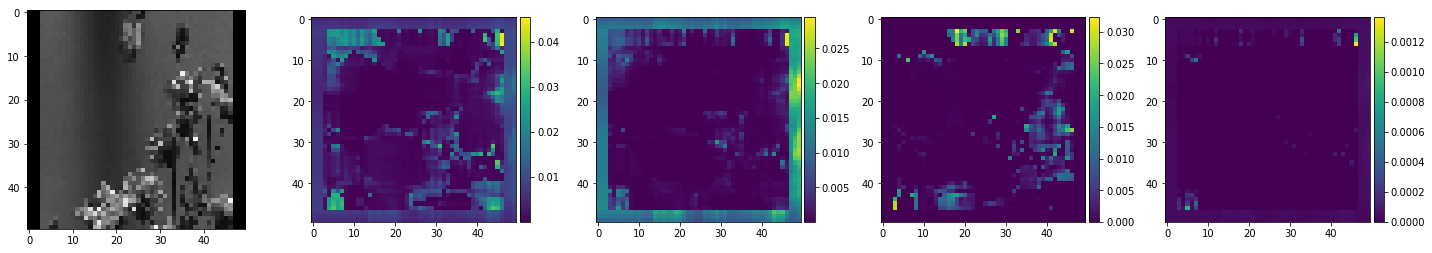

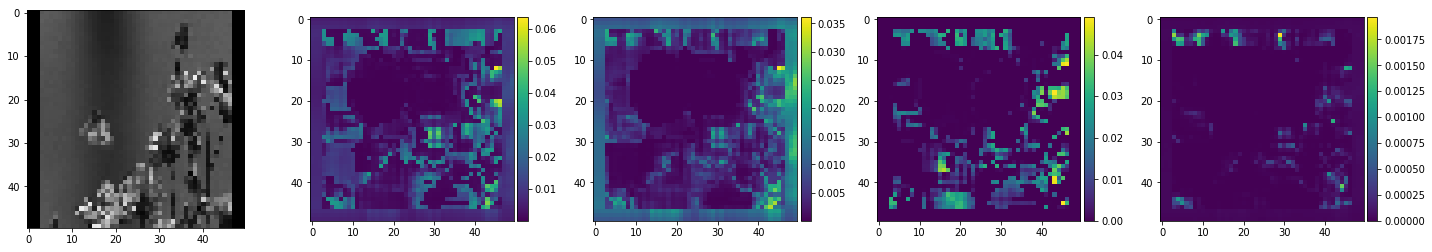

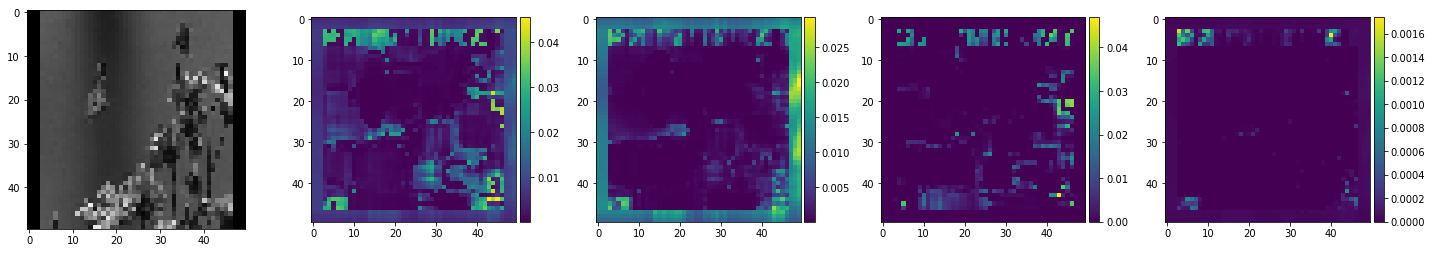

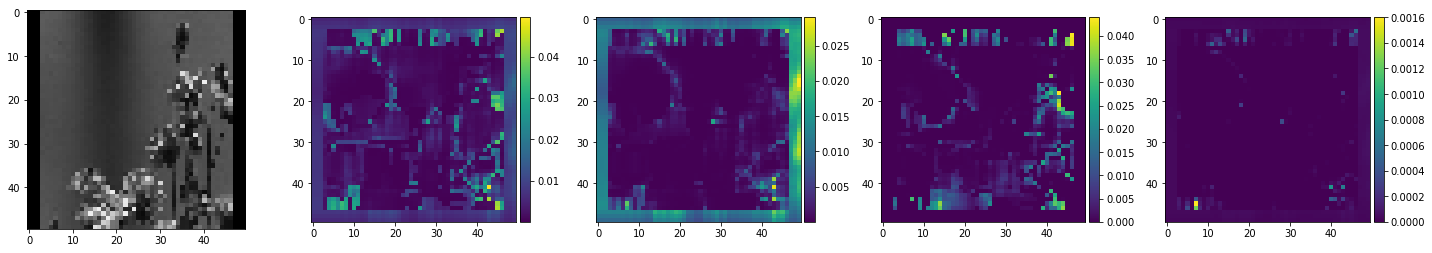

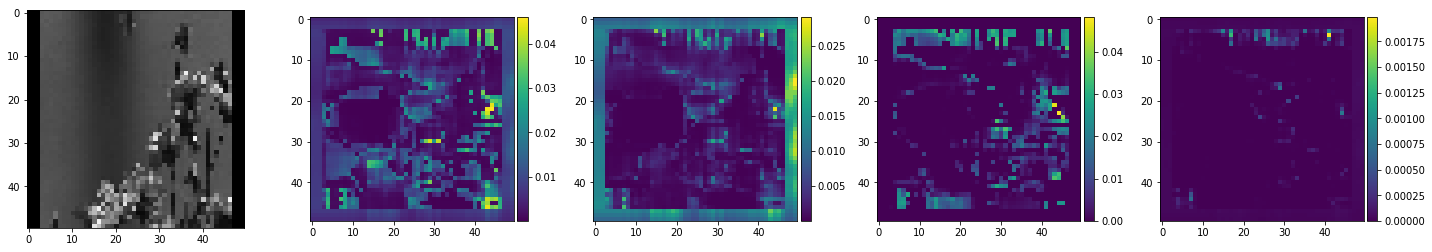

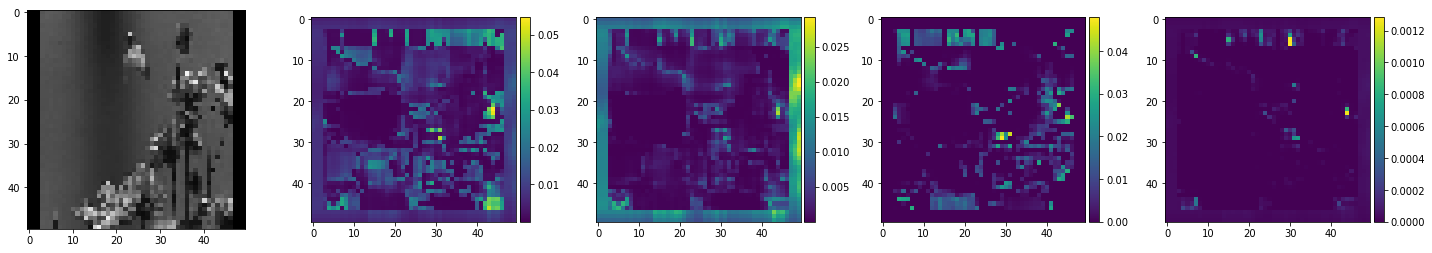

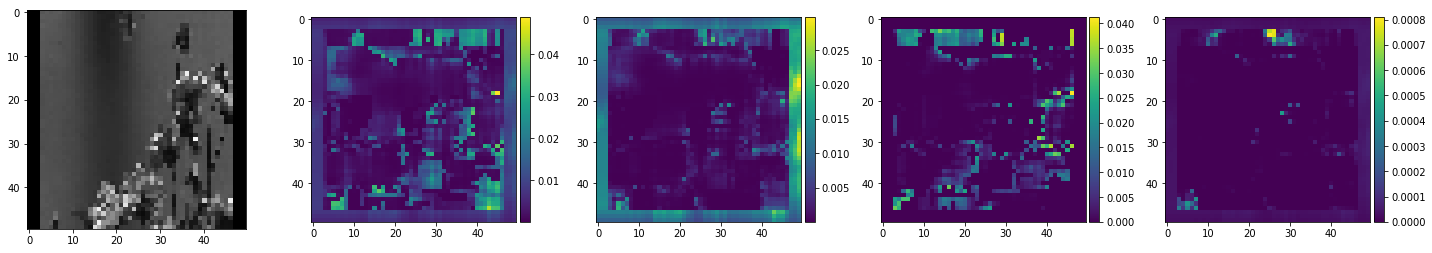

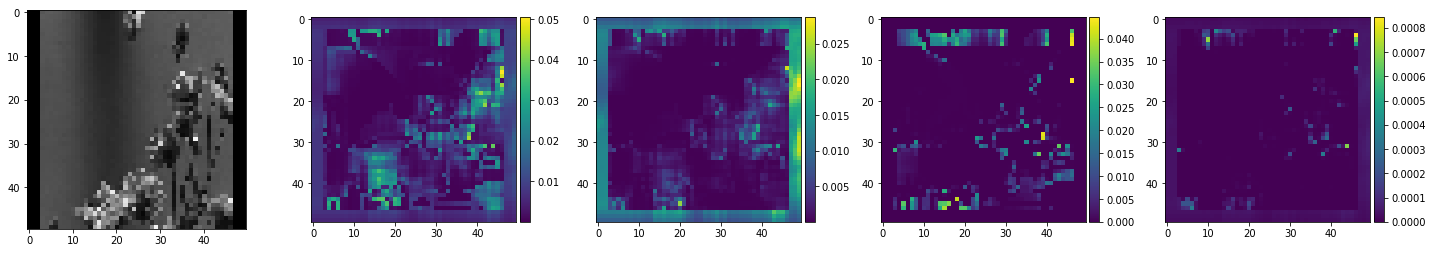

In [69]:
for i in range(0, 19):
    plt.figure(figsize=(20, 20))
    
    plt.subplot(1, 5, 1)
    io.imshow(img_seq[:, :, i])
    
    plt.subplot(1, 5, 2)
    io.imshow(mt_feat_out[i, :, :, 0])
    
    plt.subplot(1, 5, 3)
    io.imshow(mt_feat_out[i, :, :, 1])
    
    plt.subplot(1, 5, 4)
    io.imshow(mt_feat_out[i, :, :, 2])
    
    plt.subplot(1, 5, 5)
    io.imshow(mt_feat_out[i, :, :, 3])
    
    plt.show()

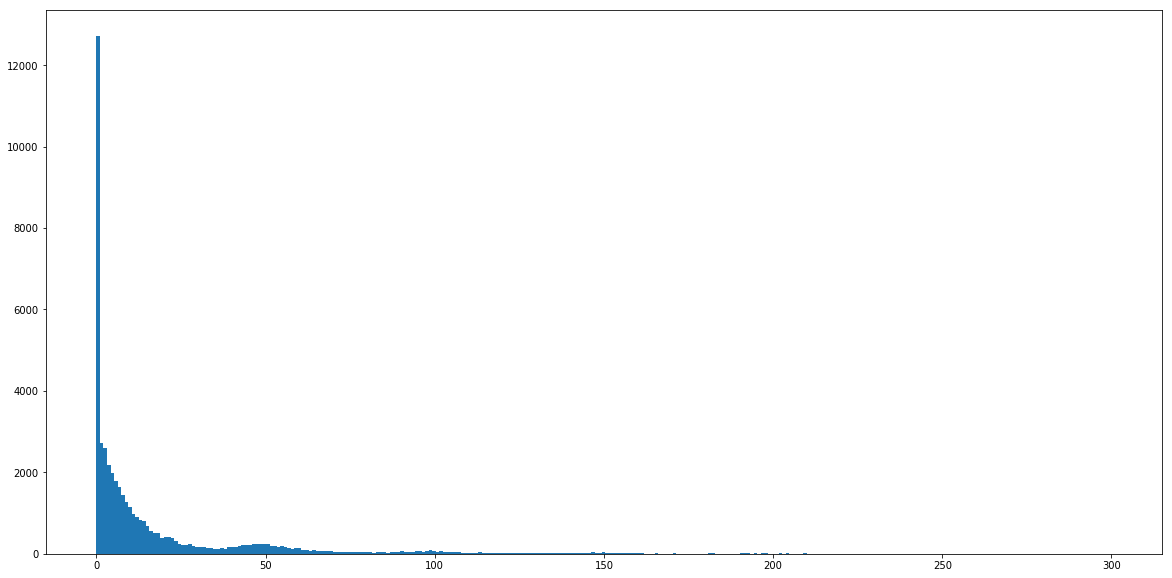

In [35]:
plt.figure(figsize=(20, 10))

plt.hist(speed.flatten() * 50, bins='auto')

plt.show()